# Project 2

This project is my first attempt at building a model to make predictions for a kaggle competition. This project will follow the general data science process, as we go through each step it will be labeled in the notebook below.

# Step 1: Define the Problem

The website Zillow wants to create a "market value" tool that will allow customers using their site to see an estimated price for any home they list on the site. This tool should be able to generalize to all houses within the city of Ames, Iowa. 

# Step 2: Gather data

Data was provided for this project, in the form of a .csv file. The csv file contained information on approximately 2,000 houses that were sold between 2005 and 2010 in Ames, with 80 features given for each sale.

# Step 3: Exploratory Data Analysis

Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from functools import reduce
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
# Read in original data and save it to houses. Make a copy df that will be manipulated
houses = pd.read_csv('../Data/train.csv')
df = houses

# Read in test data and save it to houses_holdout. Make a copy test_data that will be manipulated
houses_holdout = pd.read_csv('../Data/test.csv')
test_data = houses_holdout

In [3]:
# Find number of rows and columns using df.shape
df.shape, test_data.shape

((2051, 81), (879, 80))

This data set has 2,051 rows, and 81 columns. Each row represents one house that was sold, while each column represents one feature, or one piece of information about the specific house that was sold

In [4]:
# Investigate first 5 rows using df.head()
df.head()

Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street Alley  \
0  109  533352170           60        RL           NaN     13517   Pave   NaN   
1  544  531379050           60        RL          43.0     11492   Pave   NaN   
2  153  535304180           20        RL          68.0      7922   Pave   NaN   
3  318  916386060           60        RL          73.0      9802   Pave   NaN   
4  255  906425045           50        RL          82.0     14235   Pave   NaN   

  Lot Shape Land Contour    ...     Screen Porch Pool Area Pool QC Fence  \
0       IR1          Lvl    ...                0         0     NaN   NaN   
1       IR1          Lvl    ...                0         0     NaN   NaN   
2       Reg          Lvl    ...                0         0     NaN   NaN   
3       Reg          Lvl    ...                0         0     NaN   NaN   
4       IR1          Lvl    ...                0         0     NaN   NaN   

  Misc Feature Misc Val Mo Sold Yr Sold  Sale Type  SalePrice  
0          NaN        0       3    2010        WD      130500  
1          NaN        0       4    2009        WD      220000  
2          NaN        0       1    2010        WD      109000  
3          NaN        0       4    2010        WD      174000  
4          NaN        0       3    2010        WD      138500  

[5 rows x 81 columns]

Each row has an absolutely massive amount of information. Before moving forward, we need to determine what the data type of each column is, and how many null values are present in each column

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
Id                 2051 non-null int64
PID                2051 non-null int64
MS SubClass        2051 non-null int64
MS Zoning          2051 non-null object
Lot Frontage       1721 non-null float64
Lot Area           2051 non-null int64
Street             2051 non-null object
Alley              140 non-null object
Lot Shape          2051 non-null object
Land Contour       2051 non-null object
Utilities          2051 non-null object
Lot Config         2051 non-null object
Land Slope         2051 non-null object
Neighborhood       2051 non-null object
Condition 1        2051 non-null object
Condition 2        2051 non-null object
Bldg Type          2051 non-null object
House Style        2051 non-null object
Overall Qual       2051 non-null int64
Overall Cond       2051 non-null int64
Year Built         2051 non-null int64
Year Remod/Add     2051 non-null int64
Roof Style         20

There are a total of 11 columns stored as floats, 28 stored as integers, and 42 stored as objects. Before doing any modeling, all data that will be used in the model must be changed to numeric

In [6]:
df.describe()

Id           PID  MS SubClass  Lot Frontage       Lot Area  \
count  2051.000000  2.051000e+03  2051.000000   1721.000000    2051.000000   
mean   1474.033642  7.135900e+08    57.008776     69.055200   10065.208191   
std     843.980841  1.886918e+08    42.824223     23.260653    6742.488909   
min       1.000000  5.263011e+08    20.000000     21.000000    1300.000000   
25%     753.500000  5.284581e+08    20.000000     58.000000    7500.000000   
50%    1486.000000  5.354532e+08    50.000000     68.000000    9430.000000   
75%    2198.000000  9.071801e+08    70.000000     80.000000   11513.500000   
max    2930.000000  9.241520e+08   190.000000    313.000000  159000.000000   

       Overall Qual  Overall Cond   Year Built  Year Remod/Add  Mas Vnr Area  \
count   2051.000000   2051.000000  2051.000000     2051.000000   2029.000000   
mean       6.112140      5.562165  1971.708922     1984.190151     99.695909   
std        1.426271      1.104497    30.177889       21.036250    174.963129   
min        1.000000      1.000000  1872.000000     1950.000000      0.000000   
25%        5.000000      5.000000  1953.500000     1964.500000      0.000000   
50%        6.000000      5.000000  1974.000000     1993.000000      0.000000   
75%        7.000000      6.000000  2001.000000     2004.000000    161.000000   
max       10.000000      9.000000  2010.000000     2010.000000   1600.000000   

           ...        Wood Deck SF  Open Porch SF  Enclosed Porch  \
count      ...         2051.000000    2051.000000     2051.000000   
mean       ...           93.833740      47.556802       22.571916   
std        ...          128.549416      66.747241       59.845110   
min        ...            0.000000       0.000000        0.000000   
25%        ...            0.000000       0.000000        0.000000   
50%        ...            0.000000      27.000000        0.000000   
75%        ...          168.000000      70.000000        0.000000   
max        ...         1424.000000     547.000000      432.000000   

        3Ssn Porch  Screen Porch    Pool Area      Misc Val      Mo Sold  \
count  2051.000000   2051.000000  2051.000000   2051.000000  2051.000000   
mean      2.591419     16.511458     2.397855     51.574354     6.219893   
std      25.229615     57.374204    37.782570    573.393985     2.744736   
min       0.000000      0.000000     0.000000      0.000000     1.000000   
25%       0.000000      0.000000     0.000000      0.000000     4.000000   
50%       0.000000      0.000000     0.000000      0.000000     6.000000   
75%       0.000000      0.000000     0.000000      0.000000     8.000000   
max     508.000000    490.000000   800.000000  17000.000000    12.000000   

           Yr Sold      SalePrice  
count  2051.000000    2051.000000  
mean   2007.775719  181469.701609  
std       1.312014   79258.659352  
min    2006.000000   12789.000000  
25%    2007.000000  129825.000000  
50%    2008.000000  162500.000000  
75%    2009.000000  214000.000000  
max    2010.000000  611657.000000  

[8 rows x 39 columns]

Basic info for numeric columns

Investigate number of null values

In [7]:
# Find total number of null values in the training and testing data
df.isnull().sum().sum(), test_data.isnull().sum().sum()

(9822, 4175)

In [8]:
# Find percentage of values that are null values in each column with null values and sort
# in alphabetical order
null_cols = df.isnull().sum()[df.isnull().sum() > 0]
null_cols = null_cols/2051
null_cols.sort_values(ascending=True, inplace=True)

test_nulls = test_data.isnull().sum()[test_data.isnull().sum() > 0]
test_nulls = test_nulls/879
test_nulls.sort_values(ascending=True, inplace=True)

# Set the index of the null value percentages from the test_data to match those from the training data
test_nulls = test_nulls.reindex(null_cols.index)

# Fill in any missing values (those columns with nulls in the training set but not the testing set)
# with zeros
test_nulls.fillna(0, inplace=True)

# Check to make sure that both lists of null value percentages have same length
len(null_cols), len(test_nulls)

(26, 26)

In [9]:
# Pull just those columns where there are more than 10% of values as null
null_cols_high = null_cols[null_cols > .1]
test_nulls_high = test_nulls[test_nulls > .1]

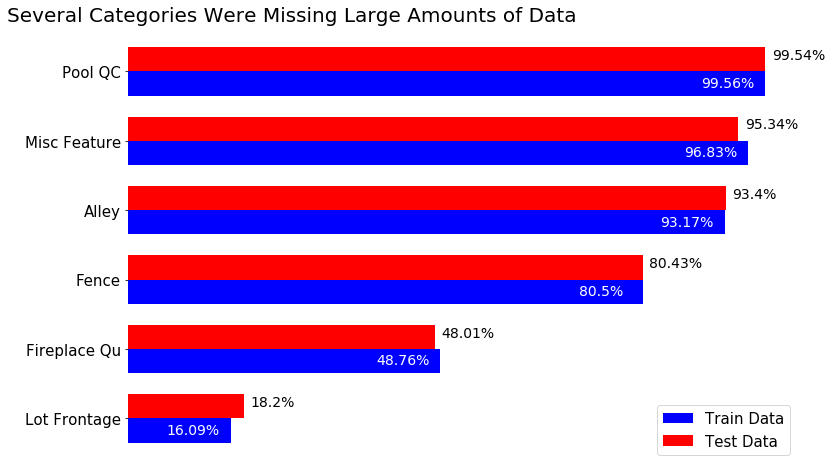

In [10]:
# Graph percentage of values that are null for those columns with more than 10% null values
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(12)

ind = np.arange(len(null_cols_high))
width = 0.35

g1 = ax.barh(ind, null_cols_high, width, color='b')
g2 = ax.barh(ind + width, test_nulls_high, width, color='r')

ax.set_title('Several Categories Were Missing Large Amounts of Data', position=(-.18,1), ha='left', size=20)
ax.set_xlabel('Null Observations (% of total)')

ax.set_yticks(ind + width/2)
ax.set_yticklabels(test_nulls_high.index, size=15)

# ax.text(x data + .01, i, label, color, size)
for i in range(len(null_cols_high)):
    ax.text(null_cols_high[i]-.1, i-.05, str(round(null_cols_high[i]*100,2)) + '%', size = 14, color = 'w')
    ax.text(test_nulls_high[i]+.01, i+width, str(round(test_nulls_high[i]*100,2)) + '%', size = 14)

ax.get_xaxis().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
    
ax.legend((g1[0], g2[0]), ('Train Data', 'Test Data'), fontsize=15)
ax.autoscale_view()
plt.savefig('null_values_barh.png', bbox_inches='tight')

In [11]:
df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False)

Pool QC           2042
Misc Feature      1986
Alley             1911
Fence             1651
Fireplace Qu      1000
Lot Frontage       330
Garage Yr Blt      114
Garage Cond        114
Garage Qual        114
Garage Finish      114
Garage Type        113
Bsmt Exposure       58
BsmtFin Type 2      56
Bsmt Cond           55
Bsmt Qual           55
BsmtFin Type 1      55
Mas Vnr Type        22
Mas Vnr Area        22
Bsmt Half Bath       2
Bsmt Full Bath       2
Garage Cars          1
BsmtFin SF 1         1
BsmtFin SF 2         1
Bsmt Unf SF          1
Garage Area          1
Total Bsmt SF        1
dtype: int64

In [12]:
test_data.isnull().sum()[test_data.isnull().sum() > 0].sort_values(ascending=False)

Pool QC           875
Misc Feature      838
Alley             821
Fence             707
Fireplace Qu      422
Lot Frontage      160
Garage Yr Blt      45
Garage Finish      45
Garage Qual        45
Garage Cond        45
Garage Type        44
BsmtFin Type 2     25
BsmtFin Type 1     25
Bsmt Exposure      25
Bsmt Cond          25
Bsmt Qual          25
Mas Vnr Area        1
Mas Vnr Type        1
Electrical          1
dtype: int64

In [13]:
# Drop those columns with over 80% null values in the training and testing data
df.drop(['Pool QC', 'Alley', 'Fence', 'Misc Feature'], axis=1, inplace=True)
test_data.drop(['Pool QC', 'Alley', 'Fence', 'Misc Feature'], axis=1, inplace=True)

## Data Cleaning

In [14]:
# Create function to find columns that contain a specific string
def col_finder(df, conditional_str):
    cols = [col for col in df.columns if conditional_str in col]
    return cols

Preprocessing

In [15]:
rating_dict = {'Ex':5, 'Gd': 4, 'TA': 3, 'Fa':2, 'Po':1, 'NA':0}

# Find all columns that use the rating system Ex, Gd, TA, Fa, Po
rating_cols = [col for col in df.columns if df[col].sort_values().iloc[0] == 'Ex']

# Remap using the dictionary created above
for col in rating_cols:
    df[col] = df[col].fillna('NA')
    df[col] = df[col].map(rating_dict)
    test_data[col] = test_data[col].fillna('NA')
    test_data[col] = test_data[col].map(rating_dict)

In [16]:
yes_no_dict = {'Y':1, 'N':0}

# Remap using the dictionary created above
df['Central Air'] = df['Central Air'].map(yes_no_dict)

test_data['Central Air'] = test_data['Central Air'].map(yes_no_dict)

In [17]:
# # This cell will create a dictionary to map values of categorical variables with fewer than 20 obesrvations to
# # 'Other' so that I have fewer columns when creating dummy varaibles with pd.get_dummies

# # sub_20_values = []
# # sub_20_cols = []
# # other_dict = {}
# # obj_cols = [col for col in df.columns if df[col].dtype == 'object']
# # for col in obj_cols:
# #     for value in df[col].unique():
# #         if type(value) == float:
# #             continue
# #         if df[col].value_counts()[value] < 20:
# #             sub_20_values.append([col, value, df[col].value_counts()[value]])
# #             sub_20_cols.append(col)
# #             if other_dict.get(col):
# #                 other_dict[col][value] = 'Other'
# #             else:
# #                 other_dict[col] = {value: 'Other'}
            

# len(sub_20_values)

# other_dict

# sub_20_cols = list(set(sub_20_cols))

In [18]:
# Create list of values to dummy
dummies = ['Garage Finish', 'Garage Type', 'Bldg Type', 'BsmtFin Type 1', 'BsmtFin Type 2',
           'Exterior 1st', 'Exterior 2nd', 'Foundation', 'Heating', 'House Style', 'Land Contour', 'Land Slope',
           'Lot Config', 'Lot Shape', 'Mas Vnr Type', 'MS SubClass', 'MS Zoning', 'Neighborhood',
           'Roof Matl', 'Roof Style', 'Street', 'Utilities', 'Condition 1', 'Condition 2', 'Bsmt Exposure',
           'Electrical', 'Functional', 'Paved Drive', 'Sale Type', 'Mo Sold', 'Yr Sold']

In [19]:
# Make sure that all categorical values from both training and testing set are listed as possible so that we can
# dummy both training and testing set and end with same columns
for col in dummies:
    df[col] = df[col].fillna('NA')
    test_data[col] = test_data[col].fillna('NA')
    train_vals = sorted(df[col].unique().tolist())
    test_vals = sorted(test_data[col].unique().tolist())
    total_vals = set(train_vals + test_vals)
    df[col] = pd.Categorical(df[col], categories=total_vals)
    test_data[col] = pd.Categorical(test_data[col], categories=total_vals)

In [20]:
# Dummy both training and testing data
df = pd.get_dummies(df, columns=dummies, drop_first=True)

test_data = pd.get_dummies(test_data, columns=dummies, drop_first=True)

In [21]:
df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False)

Lot Frontage      330
Garage Yr Blt     114
Mas Vnr Area       22
Bsmt Half Bath      2
Bsmt Full Bath      2
Garage Area         1
Garage Cars         1
Total Bsmt SF       1
Bsmt Unf SF         1
BsmtFin SF 2        1
BsmtFin SF 1        1
dtype: int64

In [22]:
test_data.isnull().sum()[test_data.isnull().sum() > 0].sort_values(ascending=False)

Lot Frontage     160
Garage Yr Blt     45
Mas Vnr Area       1
dtype: int64

In [23]:
# Find which other columns are null for the one observation of null in BsmtFin SF 1
df[df['BsmtFin SF 1'].isnull()].isnull().sum()[df[df['BsmtFin SF 1'].isnull()].isnull().sum() > 0].sort_values(ascending=False)

Bsmt Half Bath    1
Bsmt Full Bath    1
Total Bsmt SF     1
Bsmt Unf SF       1
BsmtFin SF 2      1
BsmtFin SF 1      1
dtype: int64

This one row is missing most of the information for the basement. None of these columns also contain missing data in the test set, so these features do not require cleaning across all data. Because there is no way to infer the missing information from the given information, I will drop this observation from the dataset.

In [24]:
# Drop the observation
df.drop(labels=df[df['BsmtFin SF 1'].isnull()].index[0], axis=0, inplace=True)

In [25]:
# Check to make sure just one row was dropped
df.shape

(2050, 256)

In [26]:
df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False)

Lot Frontage      330
Garage Yr Blt     114
Mas Vnr Area       22
Garage Area         1
Garage Cars         1
Bsmt Half Bath      1
Bsmt Full Bath      1
dtype: int64

In [27]:
# Check which other columns are null where Bsmt Full Bath is null
df[df['Bsmt Full Bath'].isnull()].isnull().sum()[df[df['Bsmt Full Bath'].isnull()].isnull().sum() > 0].sort_values(ascending=False)

Bsmt Half Bath    1
Bsmt Full Bath    1
dtype: int64

Drop this observation again with same rationale as above

In [28]:
df.drop(labels = df[df['Bsmt Full Bath'].isnull()].index[0], axis=0, inplace=True)

In [29]:
df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False)

Lot Frontage     330
Garage Yr Blt    114
Mas Vnr Area      22
Garage Area        1
Garage Cars        1
dtype: int64

Next I'll investigate the `Mas Vnr Area` variable

In [30]:
# Find all columns dealing with masonry
mas_cols = col_finder(df, 'Mas')
mas_cols

['Mas Vnr Area',
 'Mas Vnr Type_Stone',
 'Mas Vnr Type_CBlock',
 'Mas Vnr Type_None',
 'Mas Vnr Type_BrkFace',
 'Mas Vnr Type_NA']

In [31]:
df[df['Mas Vnr Area'].isnull()][mas_cols]

Mas Vnr Area  Mas Vnr Type_Stone  Mas Vnr Type_CBlock  \
22             NaN                   0                    0   
41             NaN                   0                    0   
86             NaN                   0                    0   
212            NaN                   0                    0   
276            NaN                   0                    0   
338            NaN                   0                    0   
431            NaN                   0                    0   
451            NaN                   0                    0   
591            NaN                   0                    0   
844            NaN                   0                    0   
913            NaN                   0                    0   
939            NaN                   0                    0   
1025           NaN                   0                    0   
1244           NaN                   0                    0   
1306           NaN                   0                    0   
1430           NaN                   0                    0   
1434           NaN                   0                    0   
1606           NaN                   0                    0   
1699           NaN                   0                    0   
1815           NaN                   0                    0   
1820           NaN                   0                    0   
1941           NaN                   0                    0   

      Mas Vnr Type_None  Mas Vnr Type_BrkFace  Mas Vnr Type_NA  
22                    0                     0                1  
41                    0                     0                1  
86                    0                     0                1  
212                   0                     0                1  
276                   0                     0                1  
338                   0                     0                1  
431                   0                     0                1  
451                   0                     0                1  
591                   0                     0                1  
844                   0                     0                1  
913                   0                     0                1  
939                   0                     0                1  
1025                  0                     0                1  
1244                  0                     0                1  
1306                  0                     0                1  
1430                  0                     0                1  
1434                  0                     0                1  
1606                  0                     0                1  
1699                  0                     0                1  
1815                  0                     0                1  
1820                  0                     0                1  
1941                  0                     0                1

In [32]:
test_data[test_data['Mas Vnr Area'].isnull()][mas_cols]

Mas Vnr Area  Mas Vnr Type_Stone  Mas Vnr Type_CBlock  Mas Vnr Type_None  \
866           NaN                   0                    0                  0   

     Mas Vnr Type_BrkFace  Mas Vnr Type_NA  
866                     0                1

All observations with null values for masonry also have null values for the masonry type. This implies that these houses do not have masonry. Therefore I will replace all null Mas Vnr Area values with 0

In [33]:
df['Mas Vnr Area'] = df['Mas Vnr Area'].fillna(0)
test_data['Mas Vnr Area'] = test_data['Mas Vnr Area'].fillna(0)

In [34]:
df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False)

Lot Frontage     330
Garage Yr Blt    114
Garage Area        1
Garage Cars        1
dtype: int64

In [35]:
test_data.isnull().sum()[test_data.isnull().sum() > 0].sort_values(ascending=False)

Lot Frontage     160
Garage Yr Blt     45
dtype: int64

In [36]:
df[df['Garage Cars'].isnull()].isnull().sum().sort_values(ascending=False).head()

Garage Yr Blt           1
Garage Cars             1
Garage Area             1
Exterior 2nd_Plywood    0
Exterior 2nd_CmentBd    0
dtype: int64

In [37]:
df[df['Garage Area'] == 0][col_finder(df,'Garage')].sum()

Garage Yr Blt            0.0
Garage Cars              0.0
Garage Area              0.0
Garage Qual              0.0
Garage Cond              0.0
Garage Finish_RFn        0.0
Garage Finish_Unf        0.0
Garage Finish_NA       113.0
Garage Type_CarPort      0.0
Garage Type_Basment      0.0
Garage Type_Attchd       0.0
Garage Type_2Types       0.0
Garage Type_Detchd       0.0
Garage Type_NA         113.0
dtype: float64

In [38]:
test_data[test_data['Garage Yr Blt'].isnull()][col_finder(test_data, 'Garage')].sum()

Garage Yr Blt            0.0
Garage Cars              1.0
Garage Area            360.0
Garage Qual              0.0
Garage Cond              0.0
Garage Finish_RFn        0.0
Garage Finish_Unf        0.0
Garage Finish_NA        45.0
Garage Type_CarPort      0.0
Garage Type_Basment      0.0
Garage Type_Attchd       0.0
Garage Type_2Types       0.0
Garage Type_Detchd       1.0
Garage Type_NA          44.0
dtype: float64

In the training data, all garages that have 0 area have 0 cars and have null values for the garage year built. This implies that the houses in these observations do not have garages. 

However, in the testing data there is one observation, index 765, where there is a garage with the house. This means that I have to replace the value for Garage Yr Blt for index 765 in the test data with a meaningful value. Since this value is impossible to know, there are a couple of options.
1. Use the year the house was built
2. Use the year of the last remodel on that house
3. The average value for Garage Yr Built from training data

In [39]:
# Find all columns dealing with garages
garage_cols = col_finder(test_data, 'Garage')

In [40]:
test_data.loc[765, garage_cols]

Garage Yr Blt            NaN
Garage Cars              1.0
Garage Area            360.0
Garage Qual              0.0
Garage Cond              0.0
Garage Finish_RFn        0.0
Garage Finish_Unf        0.0
Garage Finish_NA         1.0
Garage Type_CarPort      0.0
Garage Type_Basment      0.0
Garage Type_Attchd       0.0
Garage Type_2Types       0.0
Garage Type_Detchd       1.0
Garage Type_NA           0.0
Name: 765, dtype: float64

The null value in the garage year built corresponds with a detached garage. Since it is detached, it was likely a separate remodel after the house was built.

In [41]:
test_data.loc[765, ['Year Built', 'Year Remod/Add']]

Year Built        1910.0
Year Remod/Add    1983.0
Name: 765, dtype: float64

Since the house was last remodeled in 1983, I'll use that value as the year the garage was built

In [42]:
test_data.loc[765, 'Garage Yr Blt'] = 1983

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


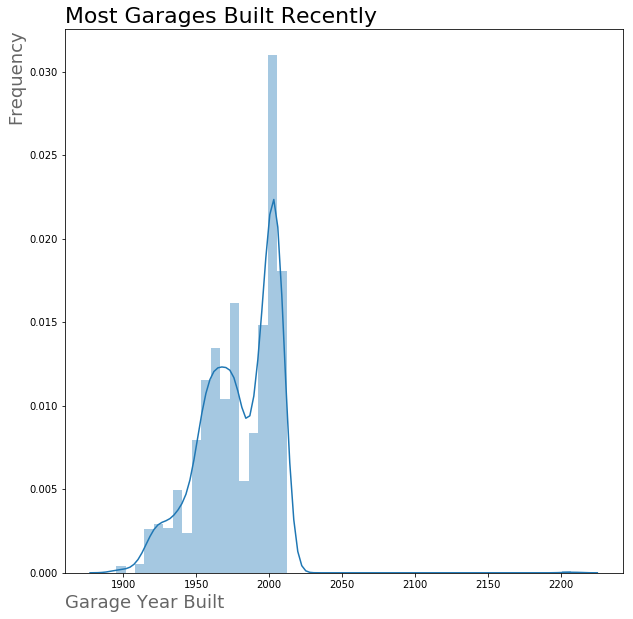

In [43]:
# Graph the distribution of garage year built for training data
plt.figure(figsize=(10, 10))
sns.distplot(df['Garage Yr Blt'][df['Garage Yr Blt'].notnull()])
plt.title('Most Garages Built Recently', position=(0,1), size=22, ha='left')
plt.ylabel('Frequency', position=(0, 1), ha='right', size=18, alpha=0.6)
plt.xlabel('Garage Year Built', position=(0,0), ha='left', size=18, alpha=0.6)
plt.savefig('garage_year_built_histogram.png', bbox_inches='tight')

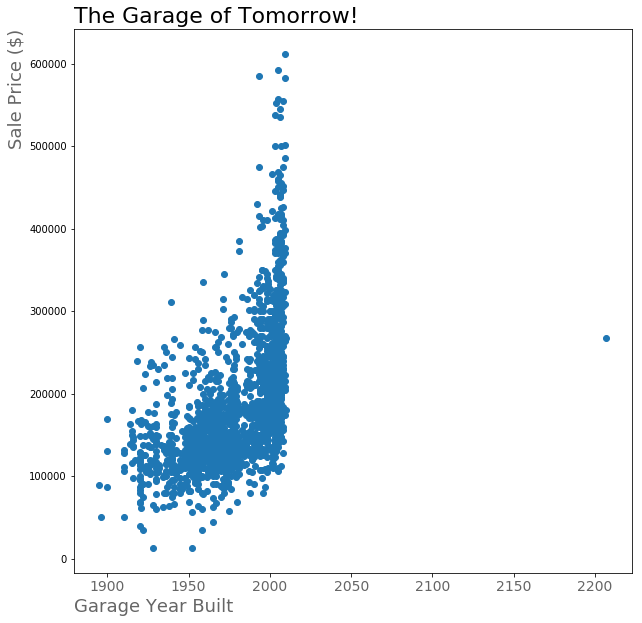

In [44]:
# Graph a scatterplot of garage year built and sale price
ind = df['Garage Yr Blt'][df['Garage Yr Blt'].notnull()]
dep = df['SalePrice'][df['Garage Yr Blt'].notnull()]

plt.figure(figsize=(10,10))
plt.scatter(ind, dep)
plt.title("The Garage of Tomorrow!", position=(0,1), size=22, ha='left')
plt.xlabel('Garage Year Built', position=(0,0), size=18, alpha=0.6, ha='left')
plt.ylabel('Sale Price ($)', position=(0, 1), size=18, alpha=0.6, ha='right')
plt.xticks(size=14, alpha=0.6)
plt.savefig('garage_of_tomorrow', bbox_inches='tight')

There is one garage that was built about 200 years in the future. Below I find and investigate that piece of information.

In [45]:
df['Garage Yr Blt'].sort_values(ascending=False).head()

1699    2207.0
144     2010.0
1241    2010.0
589     2009.0
1796    2009.0
Name: Garage Yr Blt, dtype: float64

In [46]:
df.loc[1699, ['Year Built', 'Year Remod/Add']]

Year Built        2006.0
Year Remod/Add    2007.0
Name: 1699, dtype: float64

Since the house was remodeled in 2007, I assume that 2207 was a data entry typo and that the actual year the garage was built was 2007. I replace that below.

In [47]:
df.loc[1699, 'Garage Yr Blt'] = 2007

In [48]:
# Check the correlation between garage year built and sale price
np.corrcoef(df['Garage Yr Blt'][df['Garage Yr Blt'].notnull()], df['SalePrice'][df['Garage Yr Blt'].notnull()])

array([[1.        , 0.54132641],
       [0.54132641, 1.        ]])

There is a moderate positive correlation between garage year built and sale price, so I want to make sure that this category can be modeled. I need to determine what values to use to replace nulls in this column. Below I investigate three possibilities:
1. Year the house was built
2. Year of last remodel for the house
3. The minimum non-outlier value for garage year built

In [49]:
# Find correlation when using possibility 1 to fill nulls
garage_series_2 = df['Garage Yr Blt'].copy()
for i in garage_series_2.keys():
    if garage_series_2[i] > 0:
        continue
    else:
        garage_series_2[i] = df.loc[i, 'Year Built']
        
np.corrcoef(garage_series_2, df['SalePrice'])[0][1]     

0.5565374942528655

In [50]:
# Find correlation when using possibility 2 to fill nulls
garage_series = df['Garage Yr Blt'].copy()
for i in garage_series.keys():
    if garage_series[i] > 0:
        continue
    else:
        garage_series[i] = df.loc[i, 'Year Remod/Add']

np.corrcoef(garage_series, df['SalePrice'])[0][1]

0.5355477293430541

In [51]:
# Find the lowest non-outlier value
q1, med, q3 = df['Garage Yr Blt'][df['Garage Yr Blt'].notnull()].quantile(q=[0.25,0.5,0.75])
low_outlier = med - 1.5*(q3 - q1)

# Check correlation when using lowest non-outlier value
temp = df['Garage Yr Blt'].fillna(low_outlier)
np.corrcoef(temp, df["SalePrice"])[0][1]

0.569570149385143

Option 3, using the lowest non-outlier value to fill nulls, resulted in the strongest correlation bewteen garage year built and sale price, so this is the option I will use. This also helps to prevent any additional multi-colinearity between the garage year built, year built, and year remodeled variables.

In [52]:
df['Garage Yr Blt'].fillna(low_outlier, inplace=True)
test_data['Garage Yr Blt'].fillna(low_outlier, inplace=True)

In [53]:
# Find where the garage area is null
df[df['Garage Area'].isnull()]

Id        PID  Lot Frontage  Lot Area  Overall Qual  Overall Cond  \
1712  2237  910201180          50.0      9060             5             6   

      Year Built  Year Remod/Add  Mas Vnr Area  Exter Qual      ...       \
1712        1923            1999           0.0           3      ...        

      Mo Sold_7  Mo Sold_8  Mo Sold_9  Mo Sold_10  Mo Sold_11  Mo Sold_12  \
1712          0          0          0           0           0           0   

      Yr Sold_2007  Yr Sold_2008  Yr Sold_2009  Yr Sold_2010  
1712             1             0             0             0  

[1 rows x 256 columns]

In [54]:
# Look specifically at the garage columns for where the garage area is null
df.loc[1712, garage_cols]

Garage Yr Blt          1918.5
Garage Cars               NaN
Garage Area               NaN
Garage Qual               0.0
Garage Cond               0.0
Garage Finish_RFn         0.0
Garage Finish_Unf         0.0
Garage Finish_NA          1.0
Garage Type_CarPort       0.0
Garage Type_Basment       0.0
Garage Type_Attchd        0.0
Garage Type_2Types        0.0
Garage Type_Detchd        1.0
Garage Type_NA            0.0
Name: 1712, dtype: float64

I know that this house has a detached garage, but the information on when it was built and the size of the garage are both missing. Because it is only 1 observation, I will fill in the missing values with mean estimates for all three categories.

In [55]:
df.loc[1712, ['Garage Yr Blt', 'Garage Cars', 'Garage Area']] = [df['Garage Yr Blt'].mean(), df['Garage Cars'].mean(), df['Garage Area'].mean()]

In [56]:
df.loc[1712, garage_cols]

Garage Yr Blt          1975.285993
Garage Cars               1.776855
Garage Area             473.692871
Garage Qual               0.000000
Garage Cond               0.000000
Garage Finish_RFn         0.000000
Garage Finish_Unf         0.000000
Garage Finish_NA          1.000000
Garage Type_CarPort       0.000000
Garage Type_Basment       0.000000
Garage Type_Attchd        0.000000
Garage Type_2Types        0.000000
Garage Type_Detchd        1.000000
Garage Type_NA            0.000000
Name: 1712, dtype: float64

Check for what null values remain in both data sets

In [57]:
df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False)

Lot Frontage    330
dtype: int64

In [58]:
test_data.isnull().sum()[test_data.isnull().sum() > 0].sort_values(ascending=False)

Lot Frontage    160
dtype: int64

#### Predict Lot Frontage Values for missing info

In [63]:
target = 'Lot Frontage'
features = [col for col in df.columns if col not in ['Lot Frontage', 'SalePrice', 'PID', 'Id']]

In [64]:
lot_holdout = df[df['Lot Frontage'].isnull()][features]
X_lot = df[df['Lot Frontage'].isnull() == False][features]
y_lot = df[df['Lot Frontage'].isnull() == False][target]

In [65]:
X_lot_train, X_lot_test, y_lot_train, y_lot_test = train_test_split(X_lot, y_lot, random_state=42, test_size=0.2)

ss_lot = StandardScaler()
X_lot_train_scaled = ss_lot.fit_transform(X_lot_train)
X_lot_test_scaled = ss_lot.transform(X_lot_test)

In [74]:
lr_lot = LinearRegression()
lr_lot_scores = cross_val_score(lr_lot, X_lot_train_scaled, y_lot_train)
print('MLR cross-val scores:', lr_lot_scores)
print('Average MLR score:', lr_lot_scores.mean())

MLR cross-val scores: [-2.30317171e+23 -7.06449431e+25 -8.17803098e+23]
Average MLR score: -2.3897687792935944e+25


In [66]:
alpha = np.logspace(1, 5, num=100)
ridge_lot = RidgeCV(alphas = alpha, cv=5)

ridge_lot_scores = cross_val_score(ridge_lot, X_lot_train_scaled, y_lot_train, cv=5)
print('Ridge cross-val scores:', ridge_lot_scores)
print('Average ridgeCV scores:', ridge_lot_scores.mean())

Ridge cross-val scores: [0.65398921 0.59343771 0.62093333 0.41976202 0.35218525]
Average ridgeCV scores: 0.5280615043673993


In [67]:
lasso_lot = LassoCV(cv=10, verbose=1, max_iter=2000)

lasso_scores = cross_val_score(lasso_lot, X_lot_train_scaled, y_lot_train, cv=5)
print('Lasso cross-val scores:', lasso_scores)
print('Average LassoCV scores:', lasso_scores.mean())

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Lasso cross-val scores: [0.67856761 0.63126754 0.57666328 0.43981357 0.06408767]
Average LassoCV scores: 0.4780799355753672


..........[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.3s finished


In [68]:
lasso_lot.fit(X_lot_train_scaled, y_lot_train)
lasso_lot.score(X_lot_test_scaled, y_lot_test)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.5227826385172368

In [69]:
ridge_lot.fit(X_lot_train_scaled, y_lot_train)
ridge_lot.score(X_lot_test_scaled, y_lot_test)

0.5281025125966999

Because the RidgeCV R2 scores are better, I'm going to use this rather than the mean

In [70]:
lot_holdout_scaled = ss_lot.transform(lot_holdout)

In [71]:
ridge_lot_predictions = ridge_lot.predict(lot_holdout_scaled)

In [72]:
for i in df.index:
    if df['Lot Frontage'].isnull()[i]:
        df.loc[i, 'Lot Frontage'] = ridge_lot_predictions[list(lot_holdout.index).index(i)]

In [73]:
test_lot = test_data[test_data['Lot Frontage'].isnull()][features]
test_lot_scaled = ss_lot.transform(test_lot)
ridge_holdout_predictions = ridge_lot.predict(test_lot_scaled)

for i in test_data.index:
    if test_data['Lot Frontage'].isnull()[i]:
        test_data.loc[i, 'Lot Frontage'] = ridge_holdout_predictions[list(test_lot.index).index(i)]

In [75]:
test_data.isnull().sum().sum() + df.isnull().sum().sum()

0

## Feature Engineering/Selection

Find which variables have the strongest correlation with Sale Price

In [81]:
sales_corr = df.corr().loc[:, 'SalePrice'].sort_values()
sales_corr

Garage Finish_Unf      -0.432880
Mas Vnr Type_None      -0.424582
Garage Type_Detchd     -0.369497
Foundation_CBlock      -0.355950
Lot Shape_Reg          -0.306793
MS Zoning_RM           -0.280822
PID                    -0.255412
Roof Style_Gable       -0.249569
MS SubClass_30         -0.248744
Garage Type_NA         -0.231186
Garage Finish_NA       -0.231050
Sale Type_WD           -0.214939
Neighborhood_OldTown   -0.208550
Electrical_FuseA       -0.199537
House Style_1.5Fin     -0.195973
Exterior 1st_Wd Sdng   -0.191905
Neighborhood_NAmes     -0.189557
Neighborhood_IDOTRR    -0.189395
MS SubClass_50         -0.182494
Exterior 2nd_Wd Sdng   -0.173124
BsmtFin Type 1_NA      -0.160410
BsmtFin Type 2_NA      -0.155014
Bsmt Exposure_NA       -0.153084
BsmtFin Type 1_Rec     -0.151045
Exterior 1st_MetalSd   -0.148452
Exterior 2nd_MetalSd   -0.139465
Enclosed Porch         -0.135776
Neighborhood_Sawyer    -0.133804
Neighborhood_BrkSide   -0.132402
BsmtFin Type 1_BLQ     -0.130214
          

In [111]:
len(sales_corr[abs(sales_corr) > 0.355][sales_corr<1])

30

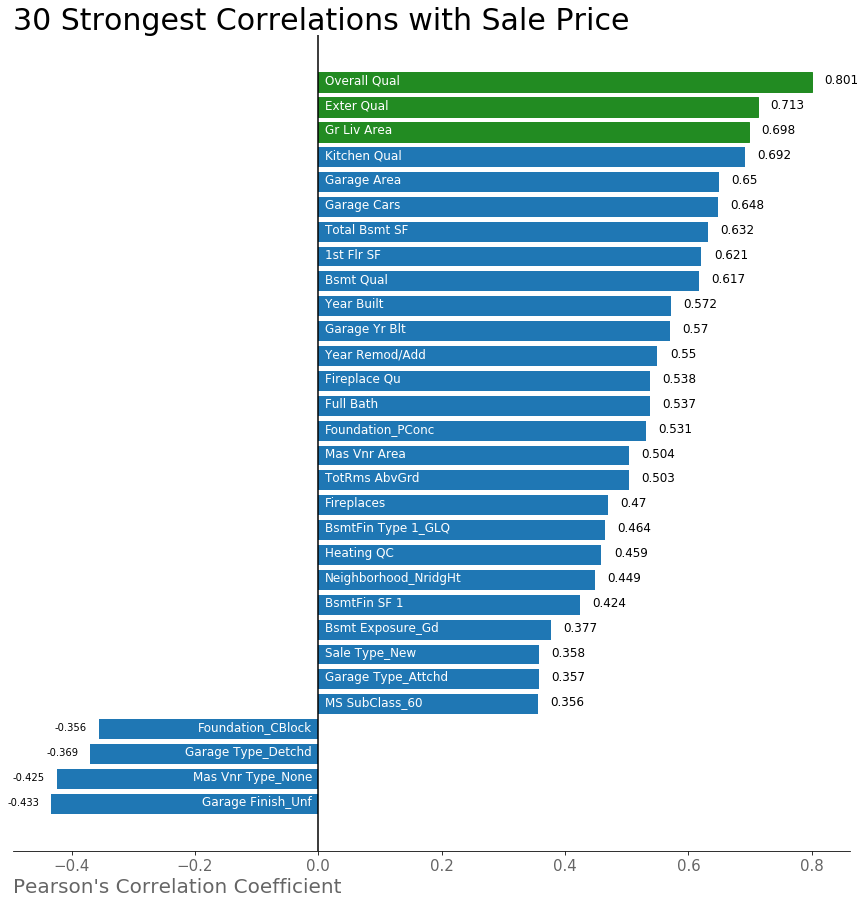

In [144]:
plt.figure(figsize=(15,15))
plt.barh(range(30),
         sales_corr[abs(sales_corr) > 0.355][sales_corr<1],
         tick_label = sales_corr[abs(sales_corr) > 0.355][sales_corr<1].keys())
plt.title("30 Strongest Correlations with Sale Price", position=(0,1), size=30, ha='left')
plt.yticks(size=15)
plt.xlabel('Pearson\'s Correlation Coefficient', position=(0,0), size=20, alpha=0.6, ha='left')
plt.xticks(size=15, alpha=0.6)
ax = plt.gca()
# ax.set_axis_off()
ax.yaxis.set_visible(False)
spine = ['left', 'right', 'top']
for s in spine:
    ax.spines[s].set_visible(False)
plt.axvline(x=0, c='k')
for i in range(4, 30):
    # ax.text(x data + .01, i, label, color, size)
    ax.text(0.01, i-0.05, sales_corr[abs(sales_corr) > 0.355][sales_corr<1].keys()[i], color = 'w', size=12)
    ax.text(sales_corr[abs(sales_corr) > 0.355][sales_corr<1][i]+0.02,
            i-0.05,
            round(sales_corr[abs(sales_corr) > 0.355][sales_corr<1][i], 3),
            size=12)
for i in range(0, 4):
    ax.text(-0.01, i-0.05, sales_corr[abs(sales_corr) > 0.355][sales_corr<1].keys()[i], color = 'w', size=12, ha='right')
    ax.text(sales_corr[abs(sales_corr) > 0.355][sales_corr<1][i]-0.02,
            i-0.05,
            round(sales_corr[abs(sales_corr) > 0.355][sales_corr<1][i], 3),
            ha='right')
recolor = [27, 28, 29]
for r in recolor:
    ax.get_children()[r].set_color('#228B22')
    
plt.savefig('strongest_correlations.png', bbox_inches='tight')

Find which variables have strong correlations with each other

In [145]:
mask = np.zeros_like(df.corr(), dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr = df.corr()

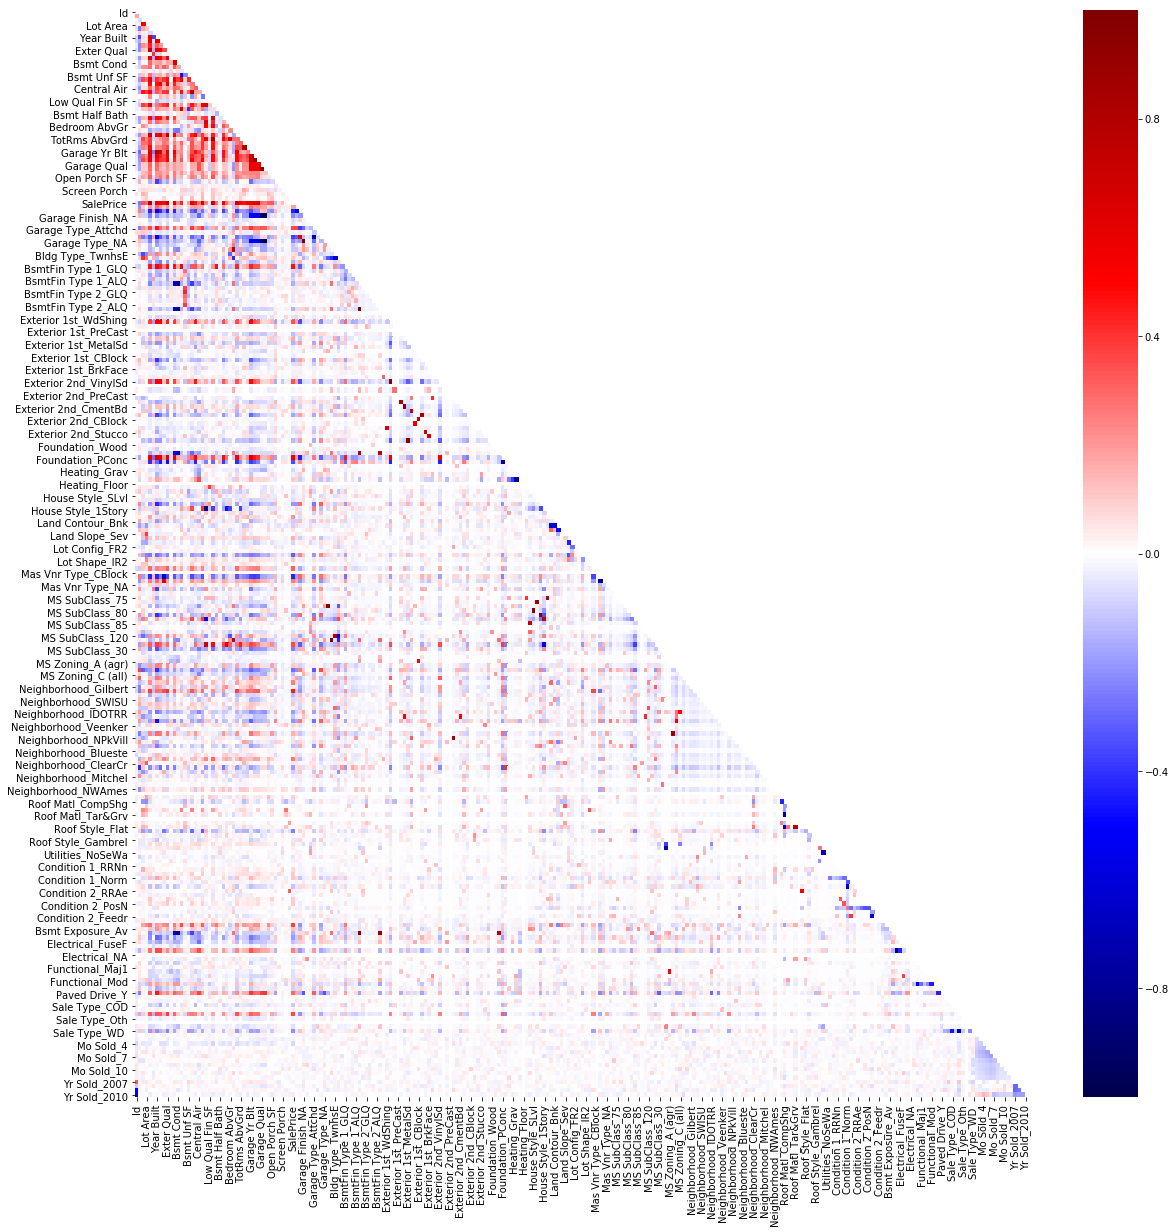

In [146]:
plt.figure(figsize=(20,20))
sns.heatmap(corr, mask=mask, cmap='seismic', vmin=-1, vmax=1)

In [147]:
non_dummy_cols = [col for col in df.columns if '_' not in col]
non_dummies = df[non_dummy_cols]
non_dummies.head()

Id        PID  Lot Frontage  Lot Area  Overall Qual  Overall Cond  \
0  109  533352170      55.76325     13517             6             8   
1  544  531379050      43.00000     11492             7             5   
2  153  535304180      68.00000      7922             5             7   
3  318  916386060      73.00000      9802             5             5   
4  255  906425045      82.00000     14235             6             8   

   Year Built  Year Remod/Add  Mas Vnr Area  Exter Qual    ...      \
0        1976            2005         289.0           4    ...       
1        1996            1997         132.0           4    ...       
2        1953            2007           0.0           3    ...       
3        2006            2007           0.0           3    ...       
4        1900            1993           0.0           3    ...       

   Garage Qual  Garage Cond  Wood Deck SF  Open Porch SF  Enclosed Porch  \
0            3            3             0             44               0   
1            3            3             0             74               0   
2            3            3             0             52               0   
3            3            3           100              0               0   
4            3            3             0             59               0   

   3Ssn Porch  Screen Porch  Pool Area  Misc Val  SalePrice  
0           0             0          0         0     130500  
1           0             0          0         0     220000  
2           0             0          0         0     109000  
3           0             0          0         0     174000  
4           0             0          0         0     138500  

[5 rows x 46 columns]

In [148]:
non_dummies.drop(['Id', 'PID'], axis=1, inplace=True)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [149]:
sns.pairplot(non_dummies)

Features with strong correlation with saleprice:
- `'Overall Qual'`
- `'Gr Liv Area'`
- `'Garage Area'`

# Step 4: Create Model

## Model 1: Overall Quality, Gr Liv Area, Garage Area

In [244]:
features = ['Overall Qual', 'Gr Liv Area', 'Garage Area']

In [151]:
X = df[features]
y = df['SalePrice']

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lr = LinearRegression()

kf = KFold(n_splits = 5, shuffle=True, random_state=8)

scores = cross_val_score(lr, X_train, y_train, cv=kf)
print(scores)
print(scores.mean())

[0.77990219 0.7803843  0.77540446 0.75390244 0.72137806]
0.7621942906609991


In [153]:
lr.fit(X_train, y_train)
lr.score(X_train, y_train)

0.7647415703601593

In [154]:
lr.score(X_test, y_test)

0.7279385936904339

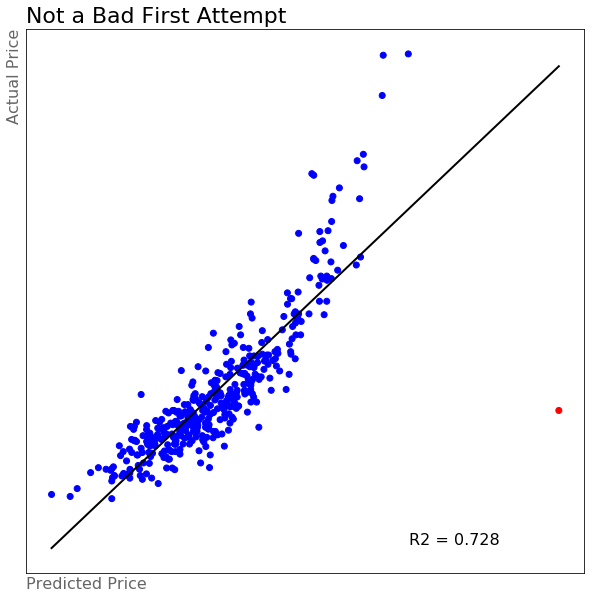

In [198]:
plt.figure(figsize=(10,10))
col = np.where(lr.predict(X_test) > 500000, 'r', 'b')
plt.scatter(lr.predict(X_test), y_test, c=col)
plt.title('Not a Bad First Attempt', position=(0,1), size=22, ha='left')
plt.xlabel('Predicted Price', position=(0,0), size=16, alpha=0.6, ha='left')
plt.ylabel('Actual Price', position=(0,1), size=16, alpha=0.6, ha='right')
plt.yticks([])
plt.xticks([])
plt.plot([min(lr.predict(X_test)), max(lr.predict(X_test))], [min(lr.predict(X_test)), max(lr.predict(X_test))], 'k-', lw=2)
ax = plt.gca()
ax.text(400000, 0, 'R2 = 0.728', size=16)

plt.savefig('model_1.png', bbox_inches='tight')


In [155]:
X_holdout = test_data[features]
predictions = lr.predict(X_holdout)

In [156]:
submission = pd.DataFrame(predictions,index=test_data['Id'])

submission.rename(columns={0:'SalePrice'}, inplace=True)
submission.head()

SalePrice
Id                 
2658  196669.254368
2718  181984.178772
2414  202225.501274
1989  124820.206129
625   176411.130664

In [157]:
submission.to_csv('../Data/submission.csv')

## Model 2 - Model 1 + neighborhood dummies

In [240]:
neighborhood_cols = [col for col in df.columns if 'Neighborhood' in col]
neighborhood_cols

['Neighborhood_CollgCr',
 'Neighborhood_StoneBr',
 'Neighborhood_Gilbert',
 'Neighborhood_NridgHt',
 'Neighborhood_Sawyer',
 'Neighborhood_SWISU',
 'Neighborhood_Timber',
 'Neighborhood_Blmngtn',
 'Neighborhood_IDOTRR',
 'Neighborhood_MeadowV',
 'Neighborhood_OldTown',
 'Neighborhood_Veenker',
 'Neighborhood_GrnHill',
 'Neighborhood_Somerst',
 'Neighborhood_NPkVill',
 'Neighborhood_Crawfor',
 'Neighborhood_BrkSide',
 'Neighborhood_Blueste',
 'Neighborhood_SawyerW',
 'Neighborhood_NoRidge',
 'Neighborhood_ClearCr',
 'Neighborhood_NAmes',
 'Neighborhood_BrDale',
 'Neighborhood_Mitchel',
 'Neighborhood_Greens',
 'Neighborhood_Landmrk',
 'Neighborhood_NWAmes']

In [245]:
features_2 = features.copy()

In [246]:
features_2

['Overall Qual', 'Gr Liv Area', 'Garage Area']

In [247]:
features_2.extend(neighborhood_cols)

In [248]:
X_2 = df[features_2]

In [249]:
X_train, X_test, y_train, y_test = train_test_split(X_2, y, test_size=0.2, random_state=8)

lr = LinearRegression()

kf = KFold(n_splits = 5, shuffle=True, random_state=8)

scores = cross_val_score(lr, X_train, y_train, cv=kf) 
print(scores) 
print(scores.mean())

[0.74799708 0.81765265 0.79301726 0.79043202 0.83650231]
0.7971202631002567


In [250]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [251]:
lr.score(X_train, y_train)

0.8098835637594736

In [252]:
lr.score(X_test, y_test)

0.8098263126259206

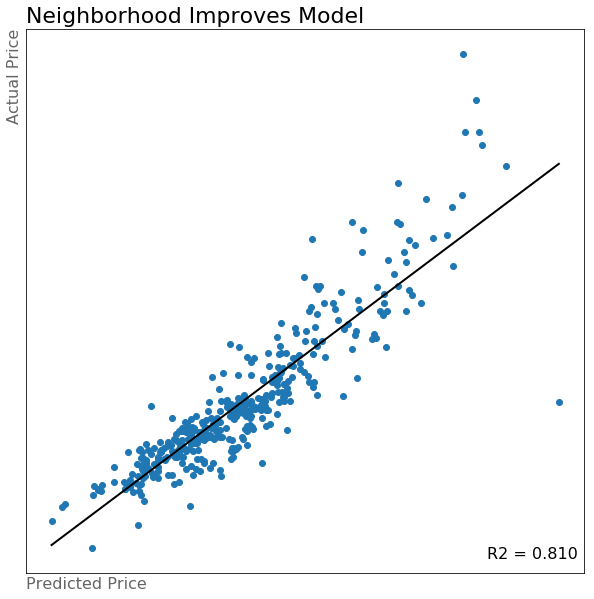

In [255]:
plt.figure(figsize=(10,10))
# col = np.where(lr.predict(X_test) > 500000, 'r', 'b')
plt.scatter(lr.predict(X_test), y_test)
plt.title('Neighborhood Improves Model', position=(0,1), size=22, ha='left')
plt.xlabel('Predicted Price', position=(0,0), size=16, alpha=0.6, ha='left')
plt.ylabel('Actual Price', position=(0,1), size=16, alpha=0.6, ha='right')
plt.yticks([])
plt.xticks([])
plt.plot([min(lr.predict(X_test)), max(lr.predict(X_test))], [min(lr.predict(X_test)), max(lr.predict(X_test))], 'k-', lw=2)
ax = plt.gca()
ax.text(400000, 0, 'R2 = 0.810', size=16)

plt.savefig('model_2.png', bbox_inches='tight')

In [256]:
test_data_copy = test_data.copy()

In [257]:
test_data.shape

(879, 255)

In [258]:
test_data_copy.shape

(879, 255)

In [259]:
X_hold = test_data_copy[features_2]

In [260]:
X_hold.shape

(879, 30)

In [261]:
predictions = lr.predict(X_hold)

In [262]:
submission = pd.DataFrame(predictions, index = test_data['Id'])

In [263]:
submission.rename(columns={0:'SalePrice'}, inplace=True)
submission.head()

SalePrice
Id                 
2658  172428.500473
2718  185949.284907
2414  193069.920809
1989  105810.402806
625   171608.003172

In [264]:
submission.to_csv('../Data/submission.csv')

# Model 3

In [266]:
features_3 = [col for col in df.columns if col not in ['SalePrice', 'PID', 'Id']]
features_3

['Lot Frontage',
 'Lot Area',
 'Overall Qual',
 'Overall Cond',
 'Year Built',
 'Year Remod/Add',
 'Mas Vnr Area',
 'Exter Qual',
 'Exter Cond',
 'Bsmt Qual',
 'Bsmt Cond',
 'BsmtFin SF 1',
 'BsmtFin SF 2',
 'Bsmt Unf SF',
 'Total Bsmt SF',
 'Heating QC',
 'Central Air',
 '1st Flr SF',
 '2nd Flr SF',
 'Low Qual Fin SF',
 'Gr Liv Area',
 'Bsmt Full Bath',
 'Bsmt Half Bath',
 'Full Bath',
 'Half Bath',
 'Bedroom AbvGr',
 'Kitchen AbvGr',
 'Kitchen Qual',
 'TotRms AbvGrd',
 'Fireplaces',
 'Fireplace Qu',
 'Garage Yr Blt',
 'Garage Cars',
 'Garage Area',
 'Garage Qual',
 'Garage Cond',
 'Wood Deck SF',
 'Open Porch SF',
 'Enclosed Porch',
 '3Ssn Porch',
 'Screen Porch',
 'Pool Area',
 'Misc Val',
 'Garage Finish_RFn',
 'Garage Finish_Unf',
 'Garage Finish_NA',
 'Garage Type_CarPort',
 'Garage Type_Basment',
 'Garage Type_Attchd',
 'Garage Type_2Types',
 'Garage Type_Detchd',
 'Garage Type_NA',
 'Bldg Type_2fmCon',
 'Bldg Type_Duplex',
 'Bldg Type_TwnhsE',
 'Bldg Type_1Fam',
 'BsmtFin Type 

In [ ]:
strong_corrs

In [272]:
X_3 = df[features_3]
y_3 = df['SalePrice']

X_3_train, X_3_test, y_3_train, y_3_test = train_test_split(X_3, y_3, test_size=0.2)

In [ ]:
corr = df.corr()
strong_corrs = {}
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        if i == j:
            continue
        if abs(corr.iloc[i, j]) > 0.7:
            if strong_corrs.get(corr.columns[i]):
                strong_corrs[corr.columns[i]].append(corr.columns[j])
            else:
                strong_corrs[corr.columns[i]] = [corr.columns[j]]

In [ ]:
from sklearn.preprocessing import StandardScaler

In [273]:
ss_3 = StandardScaler()

In [274]:
X_3_train_scaled = ss_3.fit_transform(X_train)
X_3_test_scaled = ss_3.transform(X_test)

In [275]:
lr_3 = LinearRegression()

In [276]:
cross_val_score(lr_3, X_3_train_scaled, y_3_train)

array([-2.40846397e+23, -1.58785513e+22, -1.31213479e+23])

In [277]:
lr_3.fit(X_3_train_scaled, y_3_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [278]:
lr_3.score(X_3_train_scaled, y_3_train)

0.14745374003106648

In [279]:
lr_3.score(X_3_test_scaled, y_3_test)

-1.4534906102819122e+21

Clearly this model has way too much noise compared to the signal, so at this point I need to regularize using lasso, ridge, or elasticnet.

In [285]:
unused_cols = ['SalePrice', 'Id', 'PID']
features_4 = [col for col in df.columns if col not in unused_cols]
len(features_4)

253

In [286]:
X4 = df[features_4]
y = df['SalePrice']

X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y, test_size=0.2)

### Lasso CV to cull features

In [289]:
ss_4 = StandardScaler()

In [290]:
X4_train_scaled = ss_4.fit_transform(X4_train)
X4_test_scaled = ss_4.transform(X4_test)

In [291]:
lasso_cv = LassoCV(n_alphas = 1000, cv=10, max_iter=2500)

In [292]:
scores = cross_val_score(lasso_cv, X4_train_scaled, y4_train)
print(scores)
print(scores.mean())

[0.76421882 0.86514791 0.89573139]
0.8416993717267442


In [293]:
lasso_cv.fit(X4_train_scaled, y4_train)

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=2500, n_alphas=1000, n_jobs=1, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

In [294]:
lasso_cv.score(X4_train_scaled, y4_train)

0.9146932351458491

In [295]:
lasso_cv.score(X4_test_scaled, y4_test)

0.8835094030445163

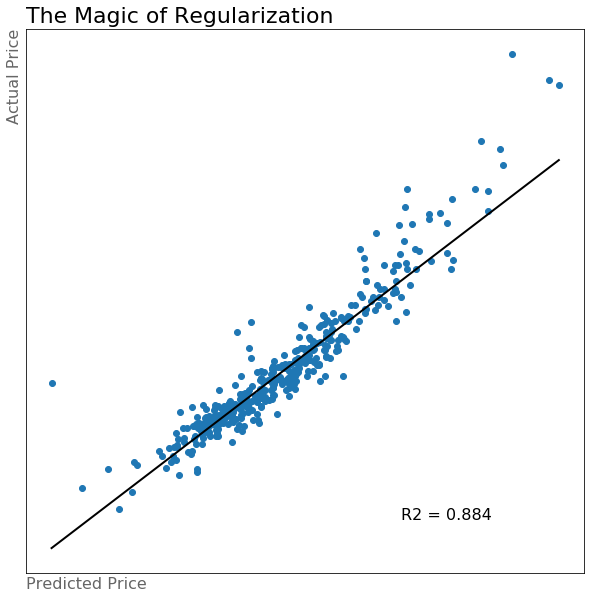

In [298]:
plt.figure(figsize=(10,10))
# col = np.where(lr.predict(X_test) > 500000, 'r', 'b')
plt.scatter(lasso_cv.predict(X4_test_scaled), y4_test)
plt.title('The Magic of Regularization', position=(0,1), size=22, ha='left')
plt.xlabel('Predicted Price', position=(0,0), size=16, alpha=0.6, ha='left')
plt.ylabel('Actual Price', position=(0,1), size=16, alpha=0.6, ha='right')
plt.yticks([])
plt.xticks([])
plt.plot([min(lasso_cv.predict(X4_test_scaled)), max(lasso_cv.predict(X4_test_scaled))],
         [min(lasso_cv.predict(X4_test_scaled)), max(lasso_cv.predict(X4_test_scaled))],
         'k-', lw=2)
ax = plt.gca()
ax.text(300000, 0, 'R2 = 0.884', size=16)

plt.savefig('model_3.png', bbox_inches='tight')

In [ ]:
X_holdout = test_data[features_4]
X_holdout_scaled = ss_4.transform(X_holdout)

predictions = lasso_cv.predict(X_holdout_scaled)

submission = pd.DataFrame(predictions,index=test_data['Id'])

submission.rename(columns={0:'SalePrice'}, inplace=True)
submission.head()

In [ ]:
submission.to_csv('../Data/submission.csv')

### Model 4: run LassoCV on polynomial predictor matrix

In [299]:
X5 = df[features_4]
y = df['SalePrice']

In [300]:
poly = PolynomialFeatures(include_bias=False)

In [301]:
X_poly = poly.fit_transform(X5)

In [302]:
X_poly_train, X_poly_test, y_poly_train, y_poly_test = train_test_split(X_poly, y, test_size=0.2)

In [303]:
ss_poly = StandardScaler()
X_poly_train_scaled = ss_poly.fit_transform(X_poly_train)
X_poly_test_scaled = ss_poly.transform(X_poly_test)

In [305]:
lasso_poly = LassoCV(verbose=1)

lp_scores = cross_val_score(lasso_poly, X_poly_train_scaled, y_poly_train)
print(lp_scores)
print(lp_scores.mean())

............................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  6.7min finished
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
............................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  8

[0.89657753 0.80946734 0.84781214]
0.8512856697212694


In [307]:
X5_hold = test_data[features_4]

X5_hold_poly = poly.transform(X5_hold)
X5_hold_poly_scaled = ss_poly.transform(X5_hold_poly)

In [308]:
lasso_poly.fit(X_poly_train_scaled, y_poly_train)
lasso_poly.score(X_poly_test_scaled, y_poly_test)

............................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 11.4min finished
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.936345011210392

In [309]:
lasso_poly.score(X_poly_test_scaled, y_poly_test)

0.936345011210392

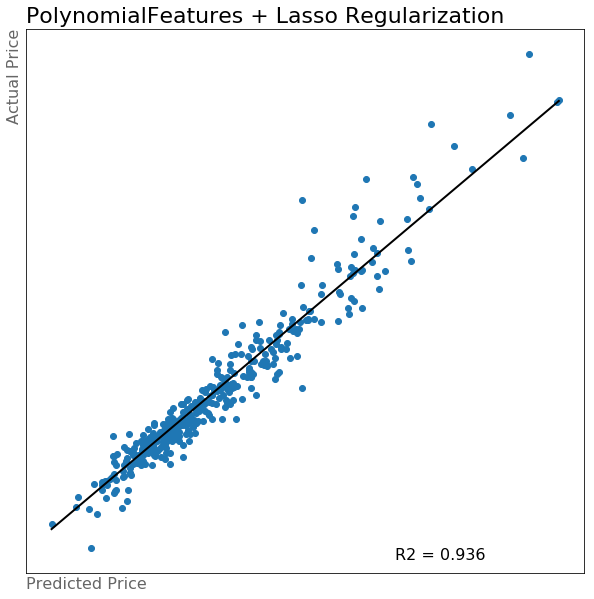

In [312]:
plt.figure(figsize=(10,10))
plt.scatter(lasso_poly.predict(X_poly_test_scaled), y_poly_test)
plt.title('PolynomialFeatures + Lasso Regularization', position=(0,1), size=22, ha='left')
plt.xlabel('Predicted Price', position=(0,0), size=16, alpha=0.6, ha='left')
plt.ylabel('Actual Price', position=(0,1), size=16, alpha=0.6, ha='right')
plt.yticks([])
plt.xticks([])
plt.plot([min(lasso_poly.predict(X_poly_test_scaled)), max(lasso_poly.predict(X_poly_test_scaled))],
         [min(lasso_poly.predict(X_poly_test_scaled)), max(lasso_poly.predict(X_poly_test_scaled))],
         'k-', lw=2)
ax = plt.gca()
ax.text(350000, 0, 'R2 = 0.936', size=16)

plt.savefig('model_4.png', bbox_inches='tight')

In [313]:
poly_preds = lasso_poly.predict(X5_hold_poly_scaled)

submission = pd.DataFrame(data=poly_preds, index=test_data['Id'])
submission.rename({0:'SalePrice'}, axis=1, inplace=True)

submission.to_csv('../Data/submission.csv')

In [407]:
lasso_poly_coefs = pd.DataFrame(lasso_poly.coef_, index=poly.get_feature_names())
abs_lasso_poly_coefs = lasso_poly_coefs[0].map(lambda cell: abs(cell))
poly_coef_values = abs_lasso_poly_coefs.sort_values(0, ascending=False).head(10).values
poly_coef_labels = abs_lasso_poly_coefs.sort_values(0, ascending=False).head(10).index

In [413]:
actual_poly_coef_labels = []
temp_labels = []
for item in poly_coef_labels:
    item = item.replace('x', '')
    feature_nums = item.split()
    for item in feature_nums:
        temp_labels.append(X5.columns[int(item)])
    actual_poly_coef_labels.append(temp_labels)
    temp_labels=[]

In [414]:
actual_poly_coef_labels = ['*'.join(x) for x in actual_poly_coef_labels]
actual_poly_coef_labels

['Land Contour_Bnk*Bsmt Exposure_Gd',
 'Overall Qual*Gr Liv Area',
 '1st Flr SF*Kitchen Qual',
 'Bsmt Qual*Total Bsmt SF',
 'Overall Qual*Exter Qual',
 'Overall Qual*Garage Area',
 'Year Built*Year Remod/Add',
 'Gr Liv Area*Kitchen Qual',
 'Overall Cond*Gr Liv Area',
 'Gr Liv Area*Functional_Typ']

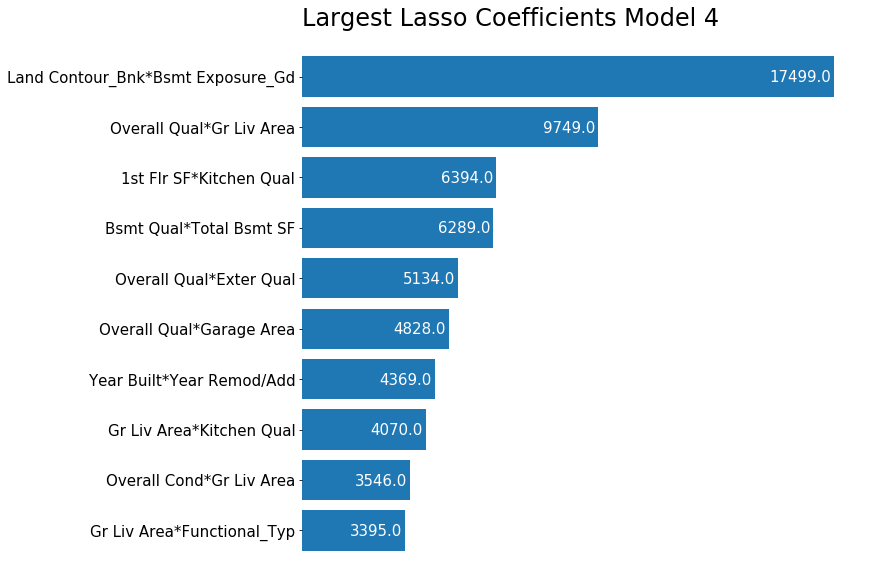

In [416]:
plt.figure(figsize=(10,10))
plt.barh(range(1, 11), poly_coef_values)
plt.yticks(range(1, 11), actual_poly_coef_labels, size=15)
plt.title('Largest Lasso Coefficients Model 4', position=(0,1), size=24, ha='left')
ax = plt.gca()
ax.invert_yaxis()
spine = ['left', 'right', 'top', 'bottom']
for s in spine:
    ax.spines[s].set_visible(False)
ax.xaxis.set_visible(False)

for i in range(0, 10):
    ax.text(poly_coef_values[i]-100, i+1.1, round(poly_coef_values[i], 0), ha='right', size=15, color='w')
    
plt.savefig('largest_lasso_coefs_model_4.png', bbox_inches='tight')

### Searching for interaction terms to add

In [314]:
def best_degree_2_interactions(df1, target, num, df2, df3):
    interactions = []
    correlations = []
    for col in df1.columns:
        for col2 in df1.columns:
            corr = np.corrcoef(df1[col] * df1[col2], target)[0][1]
            if correlations == []:
                correlations.append(corr)
                interactions.append([col, col2])
            if abs(corr) > min(correlations):
                temp = [min([col, col2]), max([col, col2])]
                if temp in interactions:
                    continue
                correlations.append(abs(corr))
                interactions.append(temp)
                if len(correlations) > num:
                    del interactions[correlations.index(min(correlations))]
                    correlations.remove(min(correlations))
    print(interactions)
    for item in interactions:
        print(type(item))
        print(type(item[0]), type(item[1]))
        name = "*".join(item)
        df1[name] = df1[item[0]]*df1[item[1]]
        df2[name] = df2[item[0]]*df2[item[1]]
        df3[name] = df3[item[0]]*df3[item[1]]
    return None
    

In [315]:
def best_interaction_finder (df1, str_list, target, df_list):
    cols = []
    for feat in str_list:
        cols.extend(col_finder(df1, feat))
    cols = [a for a in cols if '*' not in a]
    best_r2 = 0
    feature_combo = None
    series = None
    if len(cols) < 2:
        print('Only {} columns found'.format(len(cols)))
        return None
    if len(cols) == 2:
        print('Only 2 colums found. Only returning Interaction and R2 score, not adding to DF')
        corr = np.corrcoef(df1[cols[0]]*df1[cols[1]], target)[0][1]
        name = '*'.join(cols)
        return (corr, name)
    max_combo_size= min([len(cols), 6])
    for r in range(3, max_combo_size):
        for combo in itertools.combinations(cols, r):
            temp = [df1[item] for item in list(combo)]
            interaction = reduce(lambda x, y: x*y, temp)
            corr = np.corrcoef(interaction, target)[0][1]
            if abs(corr) > best_r2:
                best_r2 = abs(corr)
                feature_combo = list(combo)
                series = interaction
    df1['*'.join(feature_combo)] = series
    for frame in df_list:
        temp_frame = [frame[item] for item in feature_combo]
        temp_interact = reduce(lambda x, y: x*y, temp_frame)
        frame['*'.join(feature_combo)] = temp_interact
    return (best_r2, '*'.join(feature_combo))

In [316]:
features_int = [col for col in df.columns if col not in ['Id', 'PID', 'SalePrice']]
X_inter = df[features_int]
y = df['SalePrice']

X_inter_train, X_inter_test, y_inter_train, y_inter_test = train_test_split(X_inter, y, test_size=0.2)

X_inter_holdout = test_data[features_int]

In [317]:
interactions_list = [
    ['Garage'], ['Bsmt'], ['Qual'], ['Area'], ['Garage', 'Qual'], ['Area', 'Qual'],
    ['Porch', 'Deck', 'Lot'], ['Year', 'Yr'], ['Kitchen'], ['Gr']
]
for item in interactions_list:
    best_interaction_finder(X_inter_train, item, y_inter_train, [X_inter_test, X_inter_holdout])

/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Only 2 colums found. Only returning Interaction and R2 score, not adding to DF


In [318]:
ss_inter = StandardScaler()

ss_inter.fit(X_inter_train)
X_inter_train_scaled = ss_inter.transform(X_inter_train)
X_inter_test_scaled = ss_inter.transform(X_inter_test)
X_inter_holdout_scaled = ss_inter.transform(X_inter_holdout)

In [319]:
lasso_inter = LassoCV()

li_scores = cross_val_score(lasso_inter, X_inter_train_scaled, y_inter_train)
print(li_scores)
print(li_scores.mean())

[0.76955185 0.91730305 0.91361188]
0.866822260108906


In [320]:
ridge_inter = RidgeCV()

ri_scores = cross_val_score(ridge_inter, X_inter_train_scaled, y_inter_train)
print(ri_scores)
print(ri_scores.mean())

[0.75576613 0.91149909 0.90700008]
0.8580884365754139


In [321]:
lasso_inter.fit(X_inter_train_scaled, y_inter_train)
lasso_inter.score(X_inter_test_scaled, y_inter_test)

0.8019484039546303

In [322]:
ridge_inter.fit(X_inter_train_scaled, y_inter_train)
ridge_inter.score(X_inter_test_scaled, y_inter_test)

0.809043285898528

In [323]:
li_preds = lasso_inter.predict(X_inter_holdout_scaled)
ri_preds = ridge_inter.predict(X_inter_holdout_scaled)

In [324]:
submission = pd.DataFrame(data=li_preds, index=test_data['Id'])
submission.columns = ['SalePrice']
submission.to_csv('../Data/submission.csv')

In [325]:
submission = pd.DataFrame(data=ri_preds, index=test_data['Id'])
submission.columns = ['SalePrice']
submission.to_csv('../Data/submission.csv')

In [326]:
def strong_2d_interactions (df1, target, df_list, strength=0.7):
    for combo in itertools.combinations(df1.columns, 2):
        cols = list(combo)
        interaction = df1[cols[0]]*df1[cols[1]]
        corr = np.corrcoef(interaction, target)[0][1]
        if abs(corr) > strength:
            df1['*'.join(cols)] = interaction
            for frame in df_list:
                f_interact = frame[cols[0]] * frame[cols[1]]
                frame['*'.join(cols)] = f_interact
    return None

In [344]:
features_int = [col for col in df.columns if col not in ['Id', 'PID', 'SalePrice']]
X_inter = df[features_int]
y = df['SalePrice']

X_inter_train, X_inter_test, y_inter_train, y_inter_test = train_test_split(X_inter, y, test_size=0.2)

X_inter_holdout = test_data[features_int]

In [345]:
strong_2d_interactions(X_inter_train, y_inter_train, [X_inter_test, X_inter_holdout], strength=0.5)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encounte

In [346]:
interactions_list = [
    ['Garage'], ['Qual'], ['Area', 'Room'], ['Garage', 'Qual'], ['Area', 'Qual'],
    ['Porch', 'Deck', 'Lot'], ['Year', 'Yr'], ['Kitchen'], ['Gr'], ['SF', 'Qual'],
    ['Type', 'Qual']
]
for item in interactions_list:
    best_interaction_finder(X_inter_train, item, y_inter_train, [X_inter_test, X_inter_holdout])

/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Only 2 colums found. Only returning Interaction and R2 score, not adding to DF


In [347]:
ss = StandardScaler()

X_inter_train_scaled = ss.fit_transform(X_inter_train)
X_inter_test_scaled = ss.transform(X_inter_test)
X_inter_holdout_scaled = ss.transform(X_inter_holdout)

In [348]:
lasso_inter = LassoCV(n_alphas = 1000, max_iter=2000, cv=5)

li_scores = cross_val_score(lasso_inter, X_inter_train_scaled, y_inter_train)
print(li_scores)
print(li_scores.mean())

[0.93596267 0.42071963 0.87294697]
0.7432097548895896


In [349]:
lasso_inter.fit(X_inter_train_scaled, y_inter_train)
lasso_inter.score(X_inter_test_scaled, y_inter_test)

0.9162259962463112

In [361]:
lasso_coefs = pd.DataFrame(lasso_inter.coef_, index=X_inter_train.columns)
abs_lasso_coefs = lasso_coefs[0].map(lambda cell: abs(cell))
coef_values = abs_lasso_coefs.sort_values(0, ascending=False).head(10).values
coef_labels = abs_lasso_coefs.sort_values(0, ascending=False).head(10).index

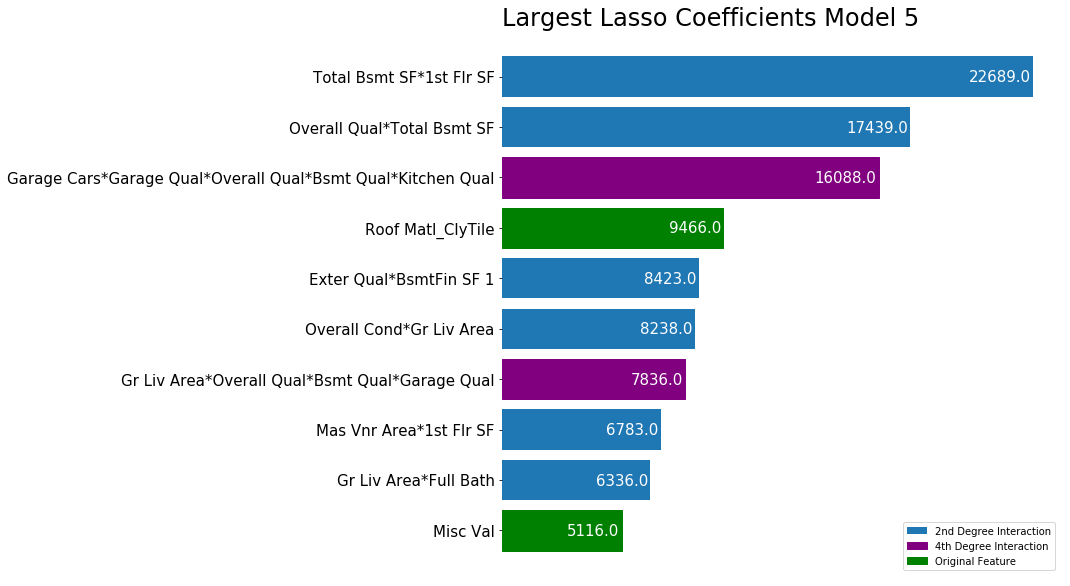

In [403]:
plt.figure(figsize=(10,10))
plt.barh(range(1, 11), coef_values)
plt.yticks(range(1, 11), coef_labels, size=15)
plt.title('Largest Lasso Coefficients Model 5', position=(0,1), size=24, ha='left')
ax = plt.gca()
ax.invert_yaxis()
spine = ['left', 'right', 'top', 'bottom']
for s in spine:
    ax.spines[s].set_visible(False)
ax.xaxis.set_visible(False)

single = [3, 9]
for b in single:
    ax.get_children()[b].set_color('green')
    ax.get_children()[b].set_label('Original Feature')
fourth_degree = [2, 6]
for b in fourth_degree:
    ax.get_children()[b].set_color('purple')
    ax.get_children()[b].set_label('4th Degree Interaction')

second_degree = [0, 1, 4, 5, 6, 7]
for b in second_degree:
    ax.get_children()[b].set_label('2nd Degree Interaction')

plt.legend([ax.get_children()[0], ax.get_children()[2], ax.get_children()[3]],
           [ax.get_children()[0].get_label(), ax.get_children()[2].get_label(), ax.get_children()[3].get_label()])

for i in range(0, 10):
    ax.text(coef_values[i]-100, i+1.1, round(coef_values[i], 0), ha='right', size=15, color='w')
    
plt.savefig('largest_lasso_coefs_model_5.png', bbox_inches='tight')

In [350]:
alpha = np.logspace(0, 5, 100)
ridge_inter = RidgeCV(alphas = alpha, cv=10)

ri_scores = cross_val_score(ridge_inter, X_inter_train_scaled, y_inter_train)
print(ri_scores)
print(ri_scores.mean())

[0.92927819 0.3741587  0.90005122]
0.7344960368347997


In [351]:
ridge_inter.fit(X_inter_train_scaled, y_inter_train)
ridge_inter.score(X_inter_test_scaled, y_inter_test)

0.911903202944477

In [352]:
ridge_inter.alpha_

376.49358067924675

In [ ]:
ri_preds = ridge_inter.predict(X_inter_holdout_scaled)
submission = pd.DataFrame(data=ri_preds, index=test_data['Id'])
submission.columns = ['SalePrice']
submission.to_csv('../Data/submission.csv')

In [342]:
l1_ratios = np.linspace(0.1, 1.0, 50)
en = ElasticNetCV(l1_ratio = l1_ratios, n_alphas = 500, cv=5, max_iter=2000)

en_scores = cross_val_score(en, X_inter_train_scaled, y_inter_train)
print(en_scores)
print(en_scores.mean())

[0.90037567 0.83270706 0.84432153]
0.8591347541610771


In [343]:
en.fit(X_inter_train_scaled, y_inter_train)
en.score(X_inter_test_scaled, y_inter_test)

0.9156999421380659

In [ ]:
en_preds = en.predict(X_inter_holdout_scaled)
submission = pd.DataFrame(data=en_preds, index=test_data['Id'])
submission.columns = ['SalePrice']
submission.to_csv('../Data/submission.csv')

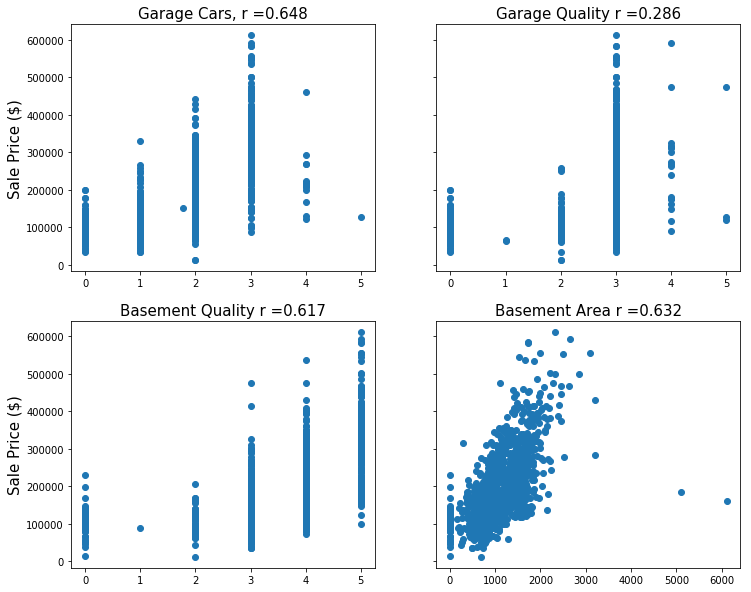

In [360]:
plt.figure(figsize=(12,10))
plt.tight_layout()
plt.title('Individual Features')

plt.subplot(2, 2, 1)
plt.scatter(df['Garage Cars'], df['SalePrice'])
plt.title('Garage Cars, r ={}'.format(round(np.corrcoef(df['Garage Cars'], df['SalePrice'])[0][1], 3)), size=15)
plt.ylabel('Sale Price ($)', size = 15)


plt.subplot(2,2,2)
plt.scatter(df['Garage Qual'], df['SalePrice'])
plt.title('Garage Quality r ={}'.format(round(np.corrcoef(df['Garage Qual'], df['SalePrice'])[0][1], 3)),
         size=15)
plt.yticks(visible=False)

plt.subplot(2,2,3)
plt.scatter(df['Bsmt Qual'], df['SalePrice'])
plt.title('Basement Quality r ={}'.format(round(np.corrcoef(df['Bsmt Qual'], df['SalePrice'])[0][1], 3)), size=15)
plt.ylabel('Sale Price ($)', size = 15)

plt.subplot(2,2,4)
plt.scatter(df['Total Bsmt SF'], df['SalePrice'])
plt.title('Basement Area r ={}'.format(round(np.corrcoef(df['Total Bsmt SF'], df['SalePrice'])[0][1], 3)),size=15)
plt.yticks(visible=False)

plt.savefig('garage_original.png', bbox_inches='tight')

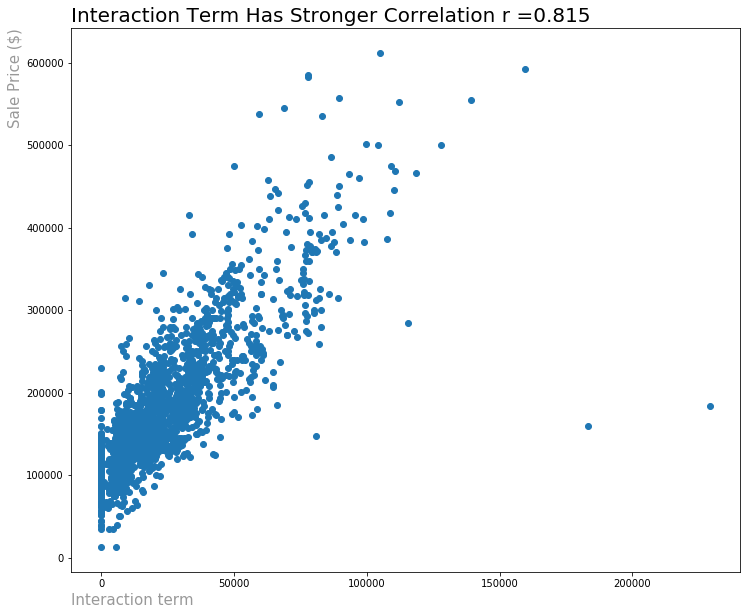

In [359]:
plt.figure(figsize=(12,10))
plt.scatter(df['Garage Cars']*df['Garage Qual']* df['Bsmt Qual']*df['Total Bsmt SF'], df['SalePrice'])
plt.title('Interaction Term Has Stronger Correlation r ={}'.format(
          round(np.corrcoef(df['Garage Cars']*df['Garage Qual']* df['Bsmt Qual']*df['Total Bsmt SF'], df['SalePrice'])[0][1], 3)),
          size=20, position=(0,1), ha='left')
plt.xlabel('Interaction term', position=(0,0), size=15, alpha=0.4, ha='left')
plt.ylabel('Sale Price ($)', position=(0,1), size=15, alpha=0.4, ha='right')
plt.savefig('garage_interaction_terms.png', bbox_inches='tight')